# Shot noise sim from ALFALFA LF

This is a copy of shotNoiseSim.ipynb, with some tweaks to use the ALFALFA luminosity function instead of the mass function. Not usable yet, a work in progress.

In [3]:
%matplotlib inline

import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt

Take Schechter function parameters from Martin et al. 2010. Explore HI mass range from 6 to 11 solar masses.

In [4]:
phi, mstar, alpha = 10.**(-4.43), -20.74, -1.20

x = np.linspace(-24, -12, 240000)

We take a conventional definition of the Schechter function. Note that it's often given as a differential, so integration is required to return the proper form. 

In [5]:
#mf = phi * (x / mstar)**(1 + alpha) * np.exp(-x / mstar) / (-1 - alpha)
mf = 0.4*np.log((10) * phi * 10**(0.4*(-x + mstar)*(alpha + 1)) *\
         np.exp(-10**(-0.4*(-x + mstar))))
print x[100000], mf[100000]

-18.9999791666 -5.01734467574


/home/nicholas/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


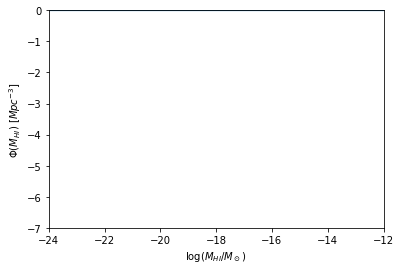

In [11]:
plt.plot(x, mf)
plt.xlim([-24., -12.])
plt.ylim([-7, 0])
plt.xlabel('log$(M_{{HI}}/M_\odot)$')
plt.ylabel('$\Phi(M_{{HI}})$ [$Mpc^{-3}$]')
plt.show()

Now we choose mass bins over which we'll integrate the function to return the number density of galaxies for each bin. We'll choose 25 bins to model Martin et al.

In [44]:
bins = np.logspace(np.log10(6), np.log10(11), 26)
nbin = np.ones_like(bins[:-1])
cent = np.ones_like(bins[:-1])

for bb in range(len(bins)-1):
    cent[bb] *= (bins[bb] + bins[bb+1]) / 2.
    #mask = (x<bins[bb+1])    
    mask = (x>=bins[bb]) & (x<bins[bb+1])
    nbin[bb] *= (integrate.simps(mf[mask], x[mask]))  
    
nbar = integrate.simps(mf, x)
mfint = np.array(nbin)

Integrating the HIMF from $M_{HI} = 10^6 M_\odot$ to $M_{HI} = 10^{11} M_{\odot}$ gives $\bar{n} = 1.98\times 10^{-1}$.

I think all I have to do to get the number of galaxies is multiply the integrated HIMF by the survey volume. The volume I've chosen is $2.67\times 10^6 \text{Mpc}^3$ from Ann Martin's PhD dissertation, altered for integer box side lengths.

In [8]:
ngal = mfint * 2.686e6

#plt.step(x, ngal)
#plt.xlim([6., 11.])
#plt.xlabel('log$(M_{{HI}}/M_\odot)$')
#plt.ylabel('$N\,(M_{{HI}})$')
#plt.yscale('log')
#plt.show()

Normalize and use as a probability distribution for placing the HI galaxies. Choose box size $139\, \text{Mpc} \times 139\, \text{Mpc} \times 139\, \text{Mpc}$.

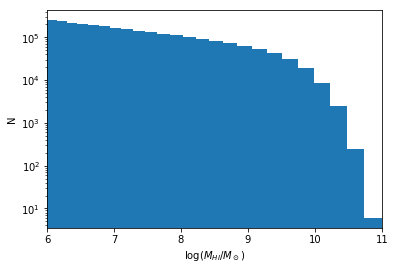

In [25]:
norm = sum(ngal)
nprob = ngal / norm

lbox = 139
box = np.random.choice(cent, size=(lbox,lbox,lbox), p=nprob)

plt.hist(box.flatten(), bins=bins)
plt.xlim([6,11])
plt.yscale('log')
plt.xlabel('log$(M_{{HI}}/M_\odot)$')
plt.ylabel('N')
plt.show()

For reference, we'll now compute the brightness temperature of each voxel, given by

$ T_{\text{HI}}(x_i) = C \, M(x_i)(N_v/V)$,

where $M(x_i)$ is the HI mass in the $i^{\text{th}}$ voxel, $N_v$ is the number of voxels, and 

$C = \frac{3hc^3 A_{10}}{32\pi m_H k_B v^2_{21}}\frac{(1+z)^2}{H(z)}$,

where $h$ is Planck's constant, $A_{10}$ is the Einstein coefficient, and $m_H$ is the mass of the H atom.

In [30]:
h = 6.62607e-34
c = 2.99792e8
A = 2.869e-15
m = 1.67372e-27
k = 1.38064e-23
v = 1.42041e9
z = 0.08
H = 2.26719e-18

C = 3 * h * c**3 * A * (1+z)**2 / (31*np.pi * m * k * v**2 * H)
# volume of box in metres (convert from Mpc)
V = (139 * 1.e6 * 3.08568025e16)**3
Nv = 139
# solar mass
Ms = 1.989e30

# convert box of masses to kg 
massbox = (10**box) * Ms
# compute box of brightness temps
Tb = C * massbox * Nv**3 / V

Above we computed the brightness temperature of the HI in each voxel. Below we'll perform a sanity check and make a histogram of the temps.

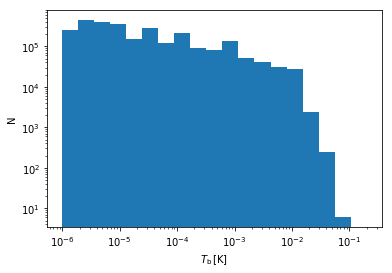

In [40]:
tempbins = np.logspace(np.log10(1.e-6), np.log10(2.e-1), 20)
plt.hist(Tb.flatten(), bins=tempbins)
plt.ylabel('N')
plt.xlabel('$T_{\mathrm{b}}\, $[K]')
plt.xscale('log')
plt.yscale('log')

In [48]:
T_b = np.mean(Tb)
0.000052**2 / nbar


1.362340279520184e-08

In [47]:
T_b**2

1.2792259297375874e-07

In [50]:
10**0.03

1.0715193052376064